# Thai2Vec Language Modeling

The goal of this notebook is to train Thai word embeddings using the [fast.ai](http://www.fast.ai/) version of [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182)--basically LSTM with droupouts--with data from [Wikipedia](https://dumps.wikimedia.org/thwiki/latest/thwiki-latest-pages-articles.xml.bz2) (pulled on January 16, 2018). We achieved perplexity of 46.61 with 51556 embeddings, compared to [state-of-the-art on November 17, 2017](https://github.com/RedditSota/state-of-the-art-result-for-machine-learning-problems) at 40.68 for English language. To the best of our knowledge, there is no comparable research in Thai language at the point of writing (January 25, 2018).

## Imports

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import re

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.learner import *
from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

from pythainlp.tokenize import word_tokenize

import dill as pickle
from IPython.display import Image
from IPython.core.display import HTML 

PATH='/home/ubuntu/data/thaiwiki/'

EXT_PATH = 'extract/'
TRN_PATH = 'train/'
VAL_PATH = 'valid/'
SAMPLE_PATH = 'sample/'

EXT = f'{PATH}{EXT_PATH}'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'
SAMPLE = f'{PATH}{SAMPLE_PATH}'

ext_files = !ls {EXT}
sample_files = !ls {SAMPLE}

## Text Cleaning

In [15]:
#!cd $PATH; ls; bzip2 -dk thwiki-latest-pages-articles.xml.bz2 
#python wikiextractor/WikiExtractor.py thwiki-latest-pages-articles.xml -o extract -b 10M --ignored_tags abbr,b,big --discard_elements gallery,timeline,noinclude

### Save as Plain Text

In [6]:
cleaned_all = []
for ext_file in ext_files:
    raw_txt = !cat {EXT}{ext_file}
    cleaned_doc = []
    for line in raw_txt:
        #remove tags
        new_line = re.sub('<[^<]+?>', '', line)
        new_line = re.sub('__[^<]+?__', '', new_line) 
        #remove ฯ but not ฯลฯ
        new_line = re.sub('(?<!ฯล)ฯ(?!ลฯ)','', new_line)
        if new_line != '':
            cleaned_doc.append(new_line)
        else:
            pass
    new_doc = '\n'.join(cleaned_doc)
    with open(f"{TRN}{ext_file}.txt", "w") as text_file:
        text_file.write(new_doc)
    text_file.close()
    cleaned_all.append(cleaned_doc)

In [7]:
trn_files = !ls {TRN}
val_files = !ls {VAL}

### Create Validation Set

In [11]:
# import random

# random.shuffle(trn_files)
# val_files = trn_files[:10]
# trn_files = trn_files[10:]

In [12]:
# import shutil, os
# for root, dirs, files in os.walk(TRN):
#     for file in files:
#         if file.endswith(".txt") & (file in val_files):
#             shutil.move(os.path.join(root, file),VAL)

In [16]:
trn_files = !ls {TRN}
val_files = !ls {VAL}

## Data Generator

### Thai Tokenizer

In [4]:
text='วิทยาศาสตร์ดาวเคราะห์เป็นสาขาวิชาที่ศึกษาเกี่ยวกับองค์ประกอบของดาวเคราะห์'
a = word_tokenize(text)
a

['วิทยาศาสตร์',
 'ดาวเคราะห์',
 'เป็น',
 'สาขาวิชา',
 'ที่',
 'ศึกษา',
 'เกี่ยวกับ',
 'องค์ประกอบ',
 'ของ',
 'ดาวเคราะห์']

### Min Count

In [11]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))
freqs = pd.DataFrame.from_dict(TEXT.vocab.freqs,orient='index')
freqs.sort_values(0,ascending=False).head(10)

,0
,7454519
ใน,710698
ที่,631102
และ,587575
เป็น,506686
ของ,498293
มี,364049
ได้,314228
"""",299321
การ,288884


In [12]:
cnt = []
for i in range(49):
    row_cnt = freqs[freqs[0]>=i+1].shape[0]
    cnt.append(row_cnt)

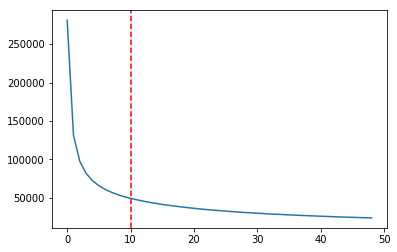

In [13]:
plt.plot(cnt)
plt.axvline(x=10,color='red', linestyle='--')

In [16]:
#number of legitimate thai words at freqs
freqs[freqs[0]<=10].sort_values(ascending=False,by=0).head(10)

,0
ชาติที่แล้ว,10
berkley,10
พันแสง,10
บักเตรี,10
correction,10
combs,10
확인.,10
curvature,10
sein,10
ngl,10


### Data Loader

In [54]:
TEXT = data.Field(lower=True, tokenize=word_tokenize)
#batch size
bs=32
#backprop through time
bptt=70

In [55]:
#FILES = dict(train=f'{SAMPLE_PATH}', validation=f'{SAMPLE_PATH}', test=f'{SAMPLE_PATH}')
FILES = dict(train=f'{TRN_PATH}', validation=f'{VAL_PATH}', test=f'{SAMPLE_PATH}')

md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=10)
#pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

In [57]:
#trn_ds is list; one for each txt file
txt = md.trn_ds[0].text[:10]
TEXT.numericalize([txt])

Variable containing:
  259
  166
    2
   19
    2
  300
    2
  301
   85
  284
[torch.cuda.LongTensor of size 10x1 (GPU 0)]

## Language Model

### Training

In [58]:
em_sz = 300  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

In [59]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [60]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 79%|███████▉  | 344/433 [00:42<00:11,  8.02it/s, loss=26.3]

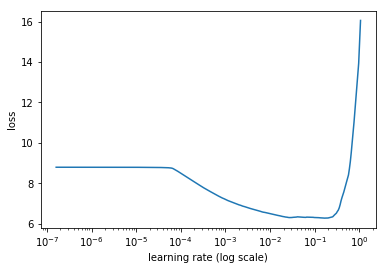

In [62]:
#find suitable learning rates
learner.lr_find(1e-07,1e2)
learner.sched.plot()

In [ ]:
#loss 3.85956; perplexity 47.44
learner.fit(1e-3, 4, wds=1e-6, cycle_len=1, cycle_mult=2)
#learner.save_encoder('adam1_enc')

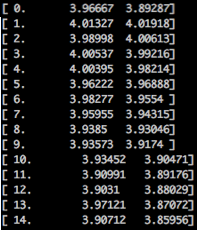

In [71]:
Image(filename= "/home/ubuntu/data/thaiwiki/png/adam1_enc.png")

In [ ]:
#loss 3.84171; perplexity 46.61
learner.fit(1e-3, 1, wds=1e-6, cycle_len=20, cycle_save_name='adam3_20')
#learner.save_encoder('adam3_enc')

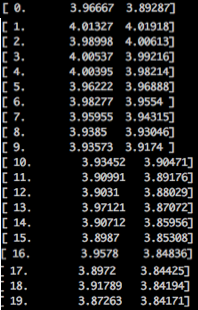

In [68]:
Image(filename= "/home/ubuntu/data/thaiwiki/png/adam3_enc.png")

### Testing

In [75]:
#m = learner.model
#pickle.dump(m,open(f'{PATH}models/wiki_lang.pkl','wb'))
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))
m = pickle.load(open(f'{PATH}models/wiki_lang.pkl','rb'))
m[0].bs=1
m.eval()

SequentialRNN (
  (0): RNN_Encoder (
    (encoder): Embedding(51556, 300, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout (
      (embed): Embedding(51556, 300, padding_idx=1)
    )
    (rnns): ModuleList (
      (0): WeightDrop (
        (module): LSTM(300, 500, dropout=0.05)
      )
      (1): WeightDrop (
        (module): LSTM(500, 500, dropout=0.05)
      )
      (2): WeightDrop (
        (module): LSTM(500, 300, dropout=0.05)
      )
    )
    (dropouti): LockedDropout (
    )
    (dropouth): LockedDropout (
    )
  )
  (1): LinearDecoder (
    (decoder): Linear (300 -> 51556)
    (dropout): LockedDropout (
    )
  )
)

In [88]:
def gen_text(ss,topk):
    s = [word_tokenize(ss)]
    t = TEXT.numericalize(s)
    m.reset()
    pred,*_ = m(t)
    pred_i = torch.topk(pred[-1], topk)[1]
    return [TEXT.vocab.itos[o] for o in to_np(pred_i)]

def gen_sentences(ss,nb_words):
    result = []
    s = [word_tokenize(ss)]
    t = TEXT.numericalize(s)
    m.reset()
    pred,*_ = m(t)
    for i in range(nb_words):
        pred_i = pred[-1].topk(2)[1]
        pred_i = pred_i[1] if pred_i.data[0] < 2 else pred_i[0]
        result.append(TEXT.vocab.itos[pred_i.data[0]])
        pred,*_ = m(pred_i[0].unsqueeze(0))
    return(result)

In [94]:
ss="""สวัสดีครับพี่น้องเสื้อ"""
gen_text(ss,10)

['แดง', 'ขาว', 'ดำ', 'เหลือง', 'หมายเลข', 'สี', 'เขียว', 'เกราะ', 'สีแดง', ' ']

In [95]:
''.join(gen_sentences(ss,50))

'แดง เป็นภาพยนตร์ไทย ออกฉายในปี พ.ศ. 2546 กำกับโดย สมชาย วงศ์สวัสดิ์ นำแสดงโดย ณัฐวุฒิ สหพงษ์ และ ณัฐวุฒิ สหพงษ์ โดยมี '

## Embeddings

### Extract

In [97]:
emb_weights = list(learner.model.named_parameters())[0][1]
emb_np = to_np(emb_weights.data)

TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))
TEXT.vocab.set_vectors(vectors=emb_weights.data,dim=300,stoi=TEXT.vocab.stoi)
#pickle.dump(TEXT, open(f'{PATH}models/TEXT_vec.pkl','wb'))

In [36]:
TEXT_vec = pickle.load(open(f'{PATH}models/TEXT_vec.pkl','rb'))

In [38]:
thai2vec = pd.DataFrame(to_np(TEXT_vec.vocab.vectors))
thai2vec.index = TEXT_vec.vocab.itos
thai2vec.head(10)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
<unk>,0.193473,0.299241,0.005685,-0.218077,0.093340,-0.058177,-0.397587,-0.040135,-0.068664,0.182962,...,0.242743,0.223673,-0.063283,0.381577,0.092275,-0.153745,-0.044563,0.292112,-0.101294,-0.164983
<pad>,0.003948,-0.017877,-0.087923,0.009941,-0.024482,-0.023072,-0.016677,-0.006310,-0.009594,0.021192,...,-0.088933,-0.012771,0.014466,-0.028766,0.027811,0.116776,0.010705,0.001330,-0.027780,-0.022937
,0.095194,-0.228250,0.120508,0.017838,-0.001278,0.027298,-2.140002,0.033625,-2.597107,0.384114,...,-0.016753,-0.025802,-0.064043,-0.129720,0.009190,0.210058,0.053755,-0.203422,-1.092552,-0.154107
ใน,-0.177850,-0.243708,0.088569,0.162008,-0.120948,-0.042076,-0.364857,-0.011825,-2.776280,-0.688595,...,0.057721,-0.131097,0.632772,0.302273,0.014868,0.398777,-0.102287,0.665936,-0.789762,-0.518877
ที่,0.308956,-0.097699,0.116745,0.215612,0.015768,-0.064163,0.062168,0.039649,0.864940,0.846904,...,-0.142418,0.033241,0.171581,-0.624864,-0.009358,0.449131,0.120130,-0.122195,-0.450617,-0.071318
และ,0.010751,-0.618971,0.129665,0.035460,-0.007560,0.027607,0.397824,0.026543,0.254075,0.168328,...,-0.105786,0.180930,-0.101630,0.070885,-0.037263,0.183606,-0.049088,-0.672288,-1.293044,0.592576
เป็น,-0.015736,-0.258926,0.052953,0.153728,-0.005985,-0.021081,0.041088,0.057312,1.633230,0.442729,...,-0.009408,-0.252576,-0.305512,0.372542,0.049151,0.568470,0.266586,0.400800,-0.784650,0.197369
ของ,-0.189711,-0.174774,0.171124,-0.186771,0.054294,-0.114150,-1.109456,-0.094466,-0.447015,0.042377,...,-0.168676,-0.148738,0.680404,0.097702,0.020270,0.182967,-0.083949,0.006287,-0.707434,-0.070234
มี,-0.156962,-0.231863,0.080312,0.323157,0.215695,0.055145,0.420794,0.016842,0.256759,0.832864,...,-0.044267,-0.147186,-0.105424,0.907078,0.009299,0.550953,0.139337,0.031696,-0.670379,-0.008048
ได้,-0.428813,-0.031194,0.041922,-0.036608,-0.008106,0.076470,-0.782270,0.033361,0.606864,0.440520,...,0.024458,-0.025031,0.103389,-0.078255,0.034323,0.459774,-0.748643,0.337775,-0.487408,-0.511535


In [39]:
thai2save = thai2vec[~thai2vec.index.str.contains(' ')]
#remove lines with weird characters due to bad segmentation
thai2save = thai2save.iloc[3:-48,:]
#thai2save.to_csv(f'{PATH}models/thai2vec.vec',sep=' ',header=False, line_terminator='\n')
#add NB_ROWS NB_COLS as header
thai2save.shape

(51358, 300)

In [45]:
#model.save_word2vec_format(f'{PATH}models/thai2vec.vec',f'{PATH}models/thai2vec.vocab',False)